In [49]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import pandas as pd
from  easydict import EasyDict

In [50]:
import torch
from sklearn.metrics import accuracy_score
import argparse

from predictor import Predictor
from datasets import *
from utils import *
from models import simple_NN

## 각각의 test frame을 추론하고, 50개(1 video = 50frame) frame을 평균내서 가장 높은 값을 가진 클래스를 할당 하는 것

In [15]:
from  easydict import EasyDict
args = EasyDict({
    "BATCH_SIZE" : 32,
    "MODEL_NAME" : 'efficientnet_b0',
    "ENSEMBLE" : None,
    "IMG_PATH" : "./data/div_2width_train/*",
    "CSV_PATH" : "./data/new_test.csv",
    "OUTPUT" : "./results/div_2width_effib0_224.csv",
    "CHECKPOINT" : ["./ckpt/div_2width_effib0_224/1E-val1.0-efficientnet_b0.pth"]
})

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = simple_NN(args.MODEL_NAME, num_classes=13).to(device)
predictor = Predictor(model, device, args)



MODEL LOAD ... from ./ckpt/div_2width_effib0_224/1E-val1.0-efficientnet_b0.pth


In [17]:
preds, pred_inds = predictor.run()

100%|██████████████████████████████████████████████████████████████████████████████████████| 2813/2813 [13:06<00:00,  3.58it/s]


In [ ]:
df = pd.DataFrame({'pred_value' : preds, 'pred_index' : pred_inds})

In [ ]:
pred_list = [0 for i in range(1800)]
cnt = 0
for j in tqdm(range(0, 90000, 50)) :    
    best_score = 0
    best_cls = 0
    for i in range(13) :
        mean_score = sum(df['pred_value'][j : j + 49][df['pred_index'] == i].values)/(len(df['pred_value'][j : j + 50][df['pred_index'] == i].values.tolist()) + +0.000001)
        if mean_score >= best_score  :
            best_score = mean_score
            best_cls = i

    pred_list[cnt] = best_cls
    cnt += 1

In [46]:
df = pd.read_csv("./data/sample_submission.csv")
df['label'] = pred_list

In [51]:
df.to_csv('./results/div_2width_effib0_224.csv', index = False)

## 이미지 channel 단위로 겹치기

In [1]:
import cv2
import os
from glob import glob
import numpy as np
import pandas as pd

import albumentations as A
from albumentations.pytorch import ToTensorV2
# from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
def collate_fn(batch):
    img_stack = []
    label_stack = []
    _transforms = A.Compose([
        A.Resize(384, 384),
        # A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False,
                    p=1.0),
    ])
    print(batch[:][0].shape)
    for img, label in batch:
        # img 나누기
#         w_ratio = int(img.shape[1] / 16)
#         h_ratio = int(img.shape[0] / 8) # 16

        label_stack.append(label)
        label_stack.append(img)
#         for w in range(16):
#             for h in range(8): # 16
#                 cropped_img = _transforms(image=img[h * h_ratio: (h + 1) * h_ratio, w * w_ratio: (w + 1) * w_ratio])['image'].transpose(2, 0, 1)
#                 img_stack.append(cropped_img.tolist())

    return torch.Tensor(img_stack), torch.Tensor(label_stack)

In [3]:
class _ChannelStackDataset(Dataset):
    def __init__(self, _df, labels, transform=None):
        self._df = _df
        self.labels = labels

        self.transform = transform

    def __len__(self):
        return len(self._df)

    def __getitem__(self, index):
        img_path = self._df['img_path'].iloc[index]
        
        # print(img_path)
        # image = cv2.imread(os.path.join('./data', *img_path.split('/')[2:]))
        image = cv2.imread(img_path)

        if self.transform :
            image = self.transform(image=image)['image']
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.labels is not None:
            label = self.labels[index]
            return image, label

        else:
            return image

In [ ]:
# if __name__ == '__main__':
csv_path = "./data/div_2width_train.csv"

df = pd.read_csv(csv_path)
label_set = df['label']
transform = A.Compose([
                A.Resize(224, 224),
                # A.Rotate(limit=(45), p=1),
                # A.RandomGridShuffle(p=grid_shuffle_p, grid=(2,2)),
                A.Normalize(),
                ToTensorV2()
            ])
ds = _ChannelStackDataset(df, label_set, transform)
dl = DataLoader(ds, batch_size=32, shuffle=False, num_workers=1)#, collate_fn=collate_fn)

for img, label in dl :
    print(img.shape)
    print(label.shape)
    break

In [5]:
ds

In [6]:
dl

In [8]:
for img, label in dl :
    print(img.shape)
    print(label.shape)
    break

NameError: name 'dl' is not defined

## timing, weather, ego-involve + crash 학습용 csv 만들기

### timing
- night = 0
- day = 1

In [36]:
path = "./data/50frame_train.csv"
df = pd.read_csv(path)
_df = df[df['label'] != 0]

new_label = [1 if label % 2 == 1 else 0 for label in _df['label'] ]
print("day : ",new_label.count(1))
print("night : ",new_label.count(0))

day :  40400
night :  5350


In [40]:
_df['label'] = new_label

path = "./data/50f_timing_train.csv"
_df.to_csv(path, index=False)

C:\Users\quhb2\AppData\Local\Temp\ipykernel_42468\3172057110.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['label'] = new_label


In [132]:
day =  40400
night =  5350
z = [5350, 40400]
np.max(z)/np.array(z)

array([7.55140187, 1.        ])

### weather
- normal = 0
- snowy = 1
- Rainy = 2

In [21]:
path = "./data/50frame_train.csv"
df = pd.read_csv(path)

_df = df[df['label'] != 0]

new_label = []
for label in _df['label'] : 
    
    # normal
    if label in [1,2,7,8] :
        new_label.append(0)
    
    # swnoy
    elif label in [3,4,9,10] :
        new_label.append(1)
    
    # rainy
    elif label in [5,6,11,12] :
        new_label.append(2)
        

print("normal : ",new_label.count(0))
print("swnoy : ",new_label.count(1))
print("rainy : ",new_label.count(2))

normal :  35800
swnoy :  6450
rainy :  3500


In [24]:
_df['label'] = new_label

path = "./data/50f_weather_train.csv"
_df.to_csv(path, index=False)

C:\Users\quhb2\AppData\Local\Temp\ipykernel_5608\279117756.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['label'] = new_label


In [143]:
normal =  35800
swnoy =  6450
rainy =  3500
z = [normal, swnoy, rainy]
np.max(z)/np.array(z)

array([ 1.        ,  5.5503876 , 10.22857143])

### ego-involve + crash 
- No ego + No crash = 0
- No ego + crash = 1
- ego + cash= 2

In [53]:
path = "./data/50frame_train.csv"
df = pd.read_csv(path)

new_label = []
for label in df['label'] :
    # No ego + No crash
    if label == 0 :
        new_label.append(0)
    
    #No ego + crash = 1
    elif label in [7, 8, 9, 10, 11, 12] : 
        new_label.append(1)
    
    # ego + cash = 2
    elif label in [1, 2, 3, 4, 5, 6] :
        new_label.append(2)
    
print("No ego + No crash : ",new_label.count(0))
print("No ego + crash : ",new_label.count(1))
print("ego + cash : ",new_label.count(2))

No ego + No crash :  89150
No ego + crash :  21200
ego + cash :  24550


In [54]:
df['label'] = new_label

path = "./data/50f_EgoCrash_train.csv"
df.to_csv(path, index=False)

In [61]:
import torch
import torch.nn as nn

In [145]:
class FocalLoss(nn.Module) :
    def __init__(self, alpha=2, gamma=2, logits=False, reduction='none') :
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets) :
        ce_loss = nn.CrossEntropyLoss(reduction=self.reduction)(inputs, targets)
        pt = torch.exp(-ce_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * ce_loss

        if self.reduction :
            return torch.mean(F_loss)
        else :
            return F_loss
        
crit = FocalLoss()
# crit = nn.BCEWithLogitsLoss().to(dtype=torch.float)

In [199]:
# a= torch.tensor([1, 0, 0, 0, 0, 1, 1, 1], dtype=torch.float)
a =  torch.tensor([1, 1,  1, 0], dtype=torch.float)
a.shape

torch.Size([4])

In [200]:
b= torch.tensor([[1, 0], [1, 0], [0, 1],[0, 1]], dtype=torch.float)
b.shape

torch.Size([4, 2])

## Ego + crash 모자이크 이미지 만들기
- 앞 쪽 20frame은 빼고 나머지 30frame으로 만들기
- 좌우에서 각각 150px씩 잘라서 만들기

In [3]:
path = "./data/50f_EgoCrash_train.csv"
df = pd.read_csv(path)

In [4]:
df['img_path']

,sample_id,img_path,label
0,TRAIN_0000_000,./data/50frame_train\TRAIN_0000_000.jpg,1
1,TRAIN_0000_001,./data/50frame_train\TRAIN_0000_001.jpg,1
2,TRAIN_0000_002,./data/50frame_train\TRAIN_0000_002.jpg,1
3,TRAIN_0000_003,./data/50frame_train\TRAIN_0000_003.jpg,1
4,TRAIN_0000_004,./data/50frame_train\TRAIN_0000_004.jpg,1
...,...,...,...
134895,TRAIN_2697_045,./data/50frame_train\TRAIN_2697_045.jpg,0
134896,TRAIN_2697_046,./data/50frame_train\TRAIN_2697_046.jpg,0
134897,TRAIN_2697_047,./data/50frame_train\TRAIN_2697_047.jpg,0
134898,TRAIN_2697_048,./data/50frame_train\TRAIN_2697_048.jpg,0


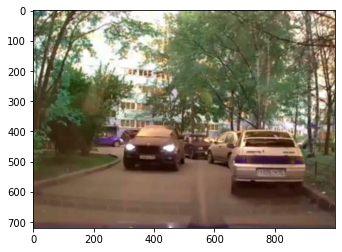

In [8]:
img = cv2.imread('./data/50frame_train\TRAIN_0000_000.jpg')
img = img[:, 140:1140, :]
plt.imshow(img)

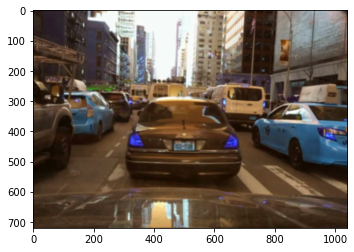

In [15]:

img = cv2.imread('./data/50frame_train\TRAIN_2697_049.jpg')
img = img[:, 120:1160, :]
plt.imshow(img)

In [14]:
1280 - 120 - 200

960

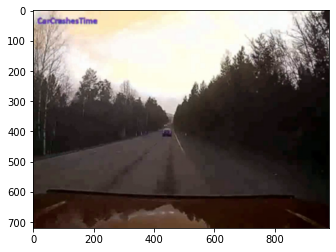

In [20]:

img = cv2.imread('./data/new_test\TEST_1271_029.jpg')
img = img[:, 150:1130, :]
plt.imshow(img)

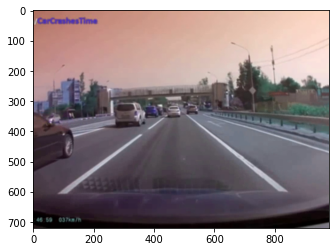

In [21]:


img = cv2.imread('./data/new_test\TEST_1280_006.jpg')
img = img[:, 150:1130, :]
plt.imshow(img)

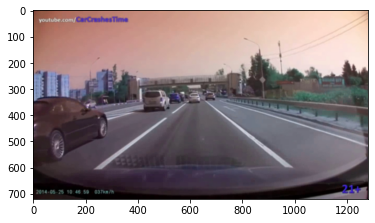

In [22]:


img = cv2.imread('./data/new_test\TEST_1280_006.jpg')
plt.imshow(img)

## weather 모자이크용  csv 만들기

In [3]:
path = './data/50f_weather_train.csv'

df = pd.read_csv(path)

label_list = []
img_path_list = []
sample_id_list = []
for i in range(int(len(df)/50)) :
    div_df = df.iloc[i*50:i*50+50]
    
    img_path = div_df['img_path'][i*50].replace('_'+div_df['img_path'][i*50].split('_')[-1], '.jpg')
    img_path = img_path.replace("/50frame_train","/mosaic_train")
    sample_id = '_'.join(div_df['sample_id'][i*50].split('_')[:2])
    
    label_list.append(div_df['label'].unique().item())
    img_path_list.append(img_path)
    sample_id_list.append(sample_id)
    
_df_ = pd.DataFrame({
    "sample_id" : sample_id_list,
    "img_path" : img_path_list,
    'label' : label_list
})

_df_.to_csv("./data/mosaic_Weather_train.csv", index=False)

## 0class 추론용 데이터로 만들기

## ensemble 해서 0번 class 라벨링

In [1]:
import torch
import os
import argparse
from tqdm import tqdm

import numpy as np
from sklearn.metrics import accuracy_score
from torch.utils.tensorboard import SummaryWriter

from predictor import Predictor
from datasets import *
from utils import *
from models import simple_NN, WEATHER_MODEL

In [2]:
from  easydict import EasyDict
args_1 = EasyDict({
    "BATCH_SIZE" : 64,
    "MODEL_NAME" : 'convnext_base_384_in22ft1k',#'efficientnet_b4',
    "ENSEMBLE" : None,
    "TYPE" : None, 
    "SUBMIT" : "./data/sample_submission.csv",
    "IMG_PATH" : 'convnext',#"./data/new_test/*", #"./data/mosaic_test/*",
    "CSV_PATH" : "./data/0class_weather.csv",
    "OUTPUT" : "./results/0class_pred_convnextB_384.csv",
    "NUM_CLASSES" : 3,
    "RESIZE" : 384,
    "CHECKPOINT" : ["./ckpt/50f_weather_0.15Normal_SimpleNN_HalfSize_OnlyBright_convnextB_384/4E-val0.9888743455497382-convnext_base_384_in22ft1k.pth",]
})
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model_1 = simple_NN(args_1.MODEL_NAME, num_classes=3).to(device)
model_1 = weight_load(model_1, None, args_1.CHECKPOINT[0], training=False)
model_1.eval()


predictor_1 = Predictor(model_1, device, args_1)
# preds = predictor.triple_model_predict(model_1, model_2, model_3)
# preds, _ = predictor.run()

MODEL LOAD ... from ./ckpt/50f_weather_0.15Normal_SimpleNN_HalfSize_OnlyBright_convnextB_384/4E-val0.9888743455497382-convnext_base_384_in22ft1k.pth
convnext


In [3]:
from  easydict import EasyDict
args_2 = EasyDict({
    "BATCH_SIZE" : 64,
    "MODEL_NAME" : 'convnext_base_384_in22ft1k',#'efficientnet_b4',
    "ENSEMBLE" : None,
    "TYPE" : None, 
    "SUBMIT" : "./data/sample_submission.csv",
    "IMG_PATH" : 'effi',#"./data/new_test/*", #"./data/mosaic_test/*",
    "CSV_PATH" : "./data/0class_weather.csv",
    "OUTPUT" : "./results/0class_pred_effiv2s_512.csv",
    "NUM_CLASSES" : 3,
    "RESIZE" : 512,
    "CHECKPOINT" : ["./ckpt/NewWeatherModel_PixLevelAug_GridShuffle_effi2s_512/4E-val0.9761125654450262-efficientnet_b0.pth"]
})
# model_2 = simple_NN(args.MODEL_NAME, num_classes=args.NUM_CLASSES).to(device)
model_2 = WEATHER_MODEL(num_classes=args_2.NUM_CLASSES).to(device)
model_2 = weight_load(model_2, None, args_2.CHECKPOINT[0], training=False)
model_2.eval()

predictor_2 = Predictor(model_2, device, args_2)
# model_3 = simple_NN(args.MODEL_NAME, num_classes=3).to(device)
# model_3 = weight_load(model_3, None, "./ckpt/50f_EgoCrash_effib0_224/10E-val0.9275194181147973-efficientnet_b0.pth", training=False)
# model_3.eval()

MODEL LOAD ... from ./ckpt/NewWeatherModel_PixLevelAug_GridShuffle_effi2s_512/4E-val0.9761125654450262-efficientnet_b0.pth
effi


In [4]:
preds_1, _ = predictor_1.run()

100%|██████████| 1393/1393 [29:36<00:00,  1.28s/it]


In [5]:
preds_2, _ = predictor_2.run()

100%|██████████| 1393/1393 [20:14<00:00,  1.15it/s]


In [6]:
display(len(preds_1))
display(len(preds_2))

89150

89150

In [28]:
pred_list = []
p_thrs = 5

for i in range(0, len(preds_1), 50) :
    # label_0 = preds_1[i : i+50].count(0) + preds_2[i : i+50].count(0)
    # label_1 = preds_1[i : i+50].count(1) + preds_2[i : i+50].count(1)
    # label_2 = preds_1[i : i+50].count(2) + preds_2[i : i+50].count(2)
    
    # if label_1 > p_thrs or label_2 > p_thrs:
    #     p_1 = 1 if label_1 > label_2 else 2
    # else :
    #     p_1 = 0
    
    # if preds_1[i : i+50].count(1) > p_thrs or preds_1[i : i+50].count(2) > p_thrs:
    #     p_1 = 1 if preds_1[i : i+50].count(1) > preds_1[i : i+50].count(2) else 2
    # else :
    #     p_1 = 0
        
    if preds_2[i : i+50].count(1) > p_thrs or preds_2[i : i+50].count(2) > p_thrs:
        p_1 = 1 if preds_2[i : i+50].count(1) > preds_2[i : i+50].count(2) else 2
    else :
        p_1 = 0
    
    
    # print([preds_1[i : i+50].count(0), preds_1[i : i+50].count(1), preds_1[i : i+50].count(2)])
    print([preds_2[i : i+50].count(0), preds_2[i : i+50].count(1), preds_2[i : i+50].count(2)])
          
    # print(int(i/50), [label_0, label_1, label_2])
    
    # pred_list.append([p_1, p_2, p_3])
    pred_list.append(p_1)

[15, 0, 35]
[50, 0, 0]
[23, 27, 0]
[30, 18, 2]
[50, 0, 0]
[50, 0, 0]
[0, 14, 36]
[50, 0, 0]
[50, 0, 0]
[27, 6, 17]
[48, 2, 0]
[50, 0, 0]
[50, 0, 0]
[47, 3, 0]
[48, 2, 0]
[45, 0, 5]
[50, 0, 0]
[50, 0, 0]
[0, 50, 0]
[0, 50, 0]
[50, 0, 0]
[50, 0, 0]
[50, 0, 0]
[50, 0, 0]
[49, 0, 1]
[50, 0, 0]
[23, 0, 27]
[48, 0, 2]
[0, 0, 50]
[48, 0, 2]
[40, 10, 0]
[50, 0, 0]
[50, 0, 0]
[50, 0, 0]
[50, 0, 0]
[50, 0, 0]
[40, 8, 2]
[50, 0, 0]
[49, 0, 1]
[50, 0, 0]
[50, 0, 0]
[50, 0, 0]
[50, 0, 0]
[50, 0, 0]
[50, 0, 0]
[50, 0, 0]
[45, 0, 5]
[0, 50, 0]
[50, 0, 0]
[50, 0, 0]
[50, 0, 0]
[0, 1, 49]
[50, 0, 0]
[50, 0, 0]
[50, 0, 0]
[50, 0, 0]
[45, 5, 0]
[43, 6, 1]
[23, 27, 0]
[50, 0, 0]
[36, 1, 13]
[1, 19, 30]
[49, 1, 0]
[9, 41, 0]
[50, 0, 0]
[50, 0, 0]
[50, 0, 0]
[50, 0, 0]
[47, 2, 1]
[0, 50, 0]
[41, 9, 0]
[50, 0, 0]
[50, 0, 0]
[24, 25, 1]
[0, 50, 0]
[24, 26, 0]
[50, 0, 0]
[31, 19, 0]
[2, 0, 48]
[50, 0, 0]
[50, 0, 0]
[50, 0, 0]
[50, 0, 0]
[50, 0, 0]
[50, 0, 0]
[50, 0, 0]
[50, 0, 0]
[35, 0, 15]
[32, 18, 0]
[1, 0,

In [23]:
df = read_csv("./data/0class_weather.csv")
df

,sample_id,img_path
0,TRAIN_0002_000,./data/50frame_train\TRAIN_0002_000.jpg
1,TRAIN_0002_001,./data/50frame_train\TRAIN_0002_001.jpg
2,TRAIN_0002_002,./data/50frame_train\TRAIN_0002_002.jpg
3,TRAIN_0002_003,./data/50frame_train\TRAIN_0002_003.jpg
4,TRAIN_0002_004,./data/50frame_train\TRAIN_0002_004.jpg
...,...,...
89145,TRAIN_2697_045,./data/50frame_train\TRAIN_2697_045.jpg
89146,TRAIN_2697_046,./data/50frame_train\TRAIN_2697_046.jpg
89147,TRAIN_2697_047,./data/50frame_train\TRAIN_2697_047.jpg
89148,TRAIN_2697_048,./data/50frame_train\TRAIN_2697_048.jpg


In [24]:
df = read_csv("./data/0class_weather.csv")
new_label = []
for idx, p in enumerate(tqdm(pred_list)) :
    new_label.extend([p]*50)
display(len(df))
display(len(new_label))

100%|██████████| 1783/1783 [00:00<00:00, 894016.02it/s]


89150

89150

In [25]:
display(len(pred_list))

save_to_csv(
        read_csv("./data/0class_weather.csv"), 
        new_label, #preds, #_pred_list, 
        "./data/0class_pred_effi2s_384.csv")

1783

In [8]:
path = "./data/50frame_train.csv"
df = pd.read_csv(path)

_df = df[df['label'] == 0]
_df = _df.drop(columns=['label'])
_df

,sample_id,img_path
100,TRAIN_0002_000,./data/50frame_train\TRAIN_0002_000.jpg
101,TRAIN_0002_001,./data/50frame_train\TRAIN_0002_001.jpg
102,TRAIN_0002_002,./data/50frame_train\TRAIN_0002_002.jpg
103,TRAIN_0002_003,./data/50frame_train\TRAIN_0002_003.jpg
104,TRAIN_0002_004,./data/50frame_train\TRAIN_0002_004.jpg
...,...,...
134895,TRAIN_2697_045,./data/50frame_train\TRAIN_2697_045.jpg
134896,TRAIN_2697_046,./data/50frame_train\TRAIN_2697_046.jpg
134897,TRAIN_2697_047,./data/50frame_train\TRAIN_2697_047.jpg
134898,TRAIN_2697_048,./data/50frame_train\TRAIN_2697_048.jpg


In [10]:
_df.to_csv('./data/0class_weather.csv', index=False)

## 0class 추론결과 합쳐서 학습 데이터로 만들기

In [4]:
p = './data/0class_pred_convb_384.csv'
df_0cls = read_csv(p)
 
p = './data/50f_weather_train.csv'
df_ori = read_csv(p)

In [6]:
display(df_0cls['label'].value_counts())
display(df_ori['label'].value_counts())

0    83100
1     4600
2     1450
Name: label, dtype: int64

0    35800
1     6450
2     3500
Name: label, dtype: int64

In [36]:
df_ori

,sample_id,img_path,label
0,TRAIN_0000_000,./data/50frame_train\TRAIN_0000_000.jpg,0
1,TRAIN_0000_001,./data/50frame_train\TRAIN_0000_001.jpg,0
2,TRAIN_0000_002,./data/50frame_train\TRAIN_0000_002.jpg,0
3,TRAIN_0000_003,./data/50frame_train\TRAIN_0000_003.jpg,0
4,TRAIN_0000_004,./data/50frame_train\TRAIN_0000_004.jpg,0
...,...,...,...
45745,TRAIN_2694_045,./data/50frame_train\TRAIN_2694_045.jpg,2
45746,TRAIN_2694_046,./data/50frame_train\TRAIN_2694_046.jpg,2
45747,TRAIN_2694_047,./data/50frame_train\TRAIN_2694_047.jpg,2
45748,TRAIN_2694_048,./data/50frame_train\TRAIN_2694_048.jpg,2


In [45]:
df = pd.concat([df_ori, df_0cls])
df = df.sort_values(by='sample_id' ,ascending=True)
df = df.reset_index(drop=True)
df

,sample_id,img_path,label
0,TRAIN_0000_000,./data/50frame_train\TRAIN_0000_000.jpg,0
1,TRAIN_0000_001,./data/50frame_train\TRAIN_0000_001.jpg,0
2,TRAIN_0000_002,./data/50frame_train\TRAIN_0000_002.jpg,0
3,TRAIN_0000_003,./data/50frame_train\TRAIN_0000_003.jpg,0
4,TRAIN_0000_004,./data/50frame_train\TRAIN_0000_004.jpg,0
...,...,...,...
134895,TRAIN_2697_045,./data/50frame_train\TRAIN_2697_045.jpg,0
134896,TRAIN_2697_046,./data/50frame_train\TRAIN_2697_046.jpg,0
134897,TRAIN_2697_047,./data/50frame_train\TRAIN_2697_047.jpg,0
134898,TRAIN_2697_048,./data/50frame_train\TRAIN_2697_048.jpg,0


In [46]:
df.to_csv('./data/50f_weather_infer0Cls_train.csv')

## 0 cls 추론 결과 중에 Rain 만 합치기

In [63]:
p = './data/0class_pred_convb_384.csv'
df_0cls = read_csv(p)
 
p = './data/50f_weather_0.35Normal_train.csv'#./data/50f_weather_0.20Normal_train.csv'#'./data/50f_weather_train.csv'
df_ori = read_csv(p)

In [64]:
df_ori['label'].value_counts()

0    12612
1     6450
2     3500
Name: label, dtype: int64

In [65]:
df_0cls = df_0cls[df_0cls['label'] == 2]
df_0cls

,sample_id,img_path,label
150,TRAIN_0008_000,./data/50frame_train\TRAIN_0008_000.jpg,2
151,TRAIN_0008_001,./data/50frame_train\TRAIN_0008_001.jpg,2
152,TRAIN_0008_002,./data/50frame_train\TRAIN_0008_002.jpg,2
153,TRAIN_0008_003,./data/50frame_train\TRAIN_0008_003.jpg,2
154,TRAIN_0008_004,./data/50frame_train\TRAIN_0008_004.jpg,2
...,...,...,...
84745,TRAIN_2559_045,./data/50frame_train\TRAIN_2559_045.jpg,2
84746,TRAIN_2559_046,./data/50frame_train\TRAIN_2559_046.jpg,2
84747,TRAIN_2559_047,./data/50frame_train\TRAIN_2559_047.jpg,2
84748,TRAIN_2559_048,./data/50frame_train\TRAIN_2559_048.jpg,2


In [66]:

df = pd.concat([df_ori, df_0cls])
df = df.sort_values(by='sample_id' ,ascending=True)
df = df.reset_index(drop=True)
df

,sample_id,img_path,label
0,TRAIN_0000_003,./data/50frame_train\TRAIN_0000_003.jpg,0
1,TRAIN_0000_004,./data/50frame_train\TRAIN_0000_004.jpg,0
2,TRAIN_0000_006,./data/50frame_train\TRAIN_0000_006.jpg,0
3,TRAIN_0000_008,./data/50frame_train\TRAIN_0000_008.jpg,0
4,TRAIN_0000_013,./data/50frame_train\TRAIN_0000_013.jpg,0
...,...,...,...
24007,TRAIN_2694_045,./data/50frame_train\TRAIN_2694_045.jpg,2
24008,TRAIN_2694_046,./data/50frame_train\TRAIN_2694_046.jpg,2
24009,TRAIN_2694_047,./data/50frame_train\TRAIN_2694_047.jpg,2
24010,TRAIN_2694_048,./data/50frame_train\TRAIN_2694_048.jpg,2


In [67]:
df.to_csv('./data/50f_weather_0.35NorminferRainOnly_train.csv', index=False)

## model predict

In [3]:
import torch
import os
import argparse
from tqdm import tqdm

import numpy as np
from sklearn.metrics import accuracy_score
from torch.utils.tensorboard import SummaryWriter

from datasets import *
from utils import *
from models import simple_NN, WEATHER_MODEL, SlowFast

In [15]:
from  easydict import EasyDict
args = EasyDict({
    "BATCH_SIZE" : 2,
    "MODEL_NAME" : 'slowfast',#'slowfast',#'convnext_base_384_in22ft1k',#'efficientnet_b4',
    "ENSEMBLE" : None,
    "TYPE" : None, 
    "RESIZE" : 224,
    "SUBMIT" : "./data/sample_submission.csv",
    "IMG_PATH" : "./data/new_test/*",#"./data/test/*", #"./data/mosaic_test/*",
    "CSV_PATH" : "./data/new_test.csv",#"./data/test.csv",
    "OUTPUT" : "./results/50f_weather_0.15NormalNoThres_gcresnext50_224.csv",
    "NUM_CLASSES" : 3,
    "CHECKPOINT" : ["./ckpt/50f_weather_0.15Normal_gcresnext50_224/12E-val0.9959759718303335-gcresnext50ts.pth"]
})

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# model_1 = simple_NN(args.MODEL_NAME, num_classes=1).to(device)
# model_1 = weight_load(model_1, None, "./ckpt/50f_timing_effib0_224/3E-val1.0-efficientnet_b0.pth", training=False)
# model_1.eval()

# model_2 = SlowFast(num_classes=args.NUM_CLASSES).to(device)
model_2 = simple_NN(args.MODEL_NAME, num_classes=args.NUM_CLASSES).to(device)
# model_2 = WEATHER_MODEL(num_classes=args.NUM_CLASSES).to(device)
model_2 = weight_load(model_2, None, args.CHECKPOINT[0], training=False)
model_2.eval()

# model_3 = simple_NN(args.MODEL_NAME, num_classes=3).to(device)
# model_3 = weight_load(model_3, None, "./ckpt/50f_EgoCrash_effib0_224/10E-val0.9275194181147973-efficientnet_b0.pth", training=False)
# model_3.eval()

simple_NN(
  (model): ByobNet(
    (stem): Stem(
      (conv1): ConvNormAct(
        (conv): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
      )
      (conv2): ConvNormAct(
        (conv): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
      )
      (conv3): ConvNormAct(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
      )
      (pool): Ma

In [6]:
from predictor import Predictor
predictor = Predictor(model_2, device, args)
# preds = predictor.triple_model_predict(model_1, model_2, model_3)
preds, _ = predictor.run()

MODEL LOAD ... from ./ckpt/50f_weather_0.15Normal_gcresnext50_224/12E-val0.9959759718303335-gcresnext50ts.pth


100%|██████████| 1407/1407 [03:27<00:00,  6.78it/s]


In [7]:
# preds[0] = list(map(lambda x: int(x[0]), preds[0]))
# preds = list(map(lambda x: int(x[0]), preds))

# display(len(preds[0]))
# display(len(preds[1]))
# display(len(preds[2]))
display(len(preds))

90000

In [17]:
# pred_list = []
# p2_thrs = 10
# for p in preds:
#     if p[1] > p2_thrs or p[2] > p2_thrs :
#         p_2 = 1 if p[1] > p[2] else 2
#     else :
#         p_2 = 0
        
#     pred_list.append(p_2)

In [16]:
pred_list = []
p2_thrs = 5
p3_thrs = 2
for i in range(0, 90000, 50) :
    # timing
    # p_2 = np.argmax([preds[i : i+50].count(0), preds[i : i+50].count(1)])
    
    # p_2 = np.argmax([preds[1][i : i+50].count(0), preds[1][i : i+50].count(1), preds[1][i : i+50].count(2)])
    # if preds[1][i : i+50].count(1) > p2_thrs or preds[1][i : i+50].count(2) > p2_thrs:
    #     p_2 = 1 if preds[1][i : i+50].count(1) > preds[1][i : i+50].count(2) else 2
    # else :
    #     p_2 = 0
    
    # weather
    # if preds[i : i+50].count(1) > p2_thrs or preds[i : i+50].count(2) > p2_thrs:
    #     p_2 = 1 if preds[i : i+50].count(1) > preds[i : i+50].count(2) else 2
    # else :
    #     p_2 = 0
    p_2 = np.argmax([preds[i : i+50].count(0), preds[i : i+50].count(1), preds[i : i+50].count(2)])
     
    # if preds[2][i : i+50].count(1) > p3_thrs or preds[2][i : i+50].count(2) > p3_thrs:
    #     p_3 = 1 if preds[2][i : i+50].count(1) > preds[2][i : i+50].count(2) else 2
    # else :
    #     p_3 = 0
    
    # print([preds[0][i : i+50].count(0), preds[0][i : i+50].count(1)], 
    #       [preds[1][i : i+50].count(0), preds[1][i : i+50].count(1), preds[1][i : i+50].count(2)], 
    #       [preds[2][i : i+50].count(0), preds[2][i : i+50].count(1), preds[2][i : i+50].count(2)]
    print(int(i/50), [preds[i : i+50].count(0), preds[i : i+50].count(1), preds[i : i+50].count(2)])
    # pred_list.append([p_1, p_2, p_3])
    pred_list.append(p_2)

0 [49, 1, 0]
1 [49, 0, 1]
2 [41, 0, 9]
3 [50, 0, 0]
4 [50, 0, 0]
5 [50, 0, 0]
6 [50, 0, 0]
7 [50, 0, 0]
8 [50, 0, 0]
9 [50, 0, 0]
10 [50, 0, 0]
11 [50, 0, 0]
12 [18, 21, 11]
13 [50, 0, 0]
14 [49, 1, 0]
15 [50, 0, 0]
16 [50, 0, 0]
17 [49, 0, 1]
18 [50, 0, 0]
19 [7, 0, 43]
20 [50, 0, 0]
21 [50, 0, 0]
22 [50, 0, 0]
23 [50, 0, 0]
24 [50, 0, 0]
25 [50, 0, 0]
26 [50, 0, 0]
27 [50, 0, 0]
28 [50, 0, 0]
29 [33, 17, 0]
30 [50, 0, 0]
31 [50, 0, 0]
32 [50, 0, 0]
33 [50, 0, 0]
34 [50, 0, 0]
35 [50, 0, 0]
36 [50, 0, 0]
37 [50, 0, 0]
38 [50, 0, 0]
39 [17, 0, 33]
40 [50, 0, 0]
41 [50, 0, 0]
42 [31, 0, 19]
43 [50, 0, 0]
44 [50, 0, 0]
45 [50, 0, 0]
46 [50, 0, 0]
47 [2, 2, 46]
48 [50, 0, 0]
49 [50, 0, 0]
50 [0, 50, 0]
51 [50, 0, 0]
52 [50, 0, 0]
53 [50, 0, 0]
54 [50, 0, 0]
55 [25, 0, 25]
56 [48, 0, 2]
57 [50, 0, 0]
58 [50, 0, 0]
59 [37, 13, 0]
60 [50, 0, 0]
61 [50, 0, 0]
62 [50, 0, 0]
63 [50, 0, 0]
64 [50, 0, 0]
65 [50, 0, 0]
66 [50, 0, 0]
67 [47, 2, 1]
68 [43, 7, 0]
69 [50, 0, 0]
70 [50, 0, 0]
71 [50, 0

In [17]:
# display(len(pred_list))
# display(pred_list[55:60])

display(len(preds))
display(preds[55:60])

90000

[0, 0, 0, 0, 0]

In [22]:
label_enc = [
    [0, 0, 0],
    [1, 0, 2],
    [0, 0, 2],
    [1, 1, 2],
    [0, 1, 2],
    [1, 2, 2],
    [0, 2, 2],
    [1, 0, 1],
    [0, 0, 1],
    [1, 1, 1],
    [0, 1, 1],
    [1, 2, 1],
    [0, 2, 1]
    ]


In [23]:
_pred_list = []
for i in pred_list :
    try : 
        _pred_list.append(label_enc.index(i))
    except :
        if i[-1] == 0 :
            _pred_list.append(0)
        else :
            print(i)

In [28]:
_pred_list.count(4)

20

In [18]:
save_to_csv(
        read_csv(args.SUBMIT), 
        pred_list, #preds, 
        args.OUTPUT)

## 3개의 csv 합치기

In [19]:
import torch
import os
import argparse
from tqdm import tqdm

import numpy as np
from sklearn.metrics import accuracy_score
from torch.utils.tensorboard import SummaryWriter

from datasets import *
from utils import *
from models import simple_NN, WEATHER_MODEL

p = "./results/50f_timing_Effib4ns_384.csv"
timing_df = read_csv(p)
p = "./results/50f_weather_0.15NormalNoThres_gcresnext50_224.csv"#50f_weather_0.15Normal_effib4ns384
weather_df = read_csv(p)
p = "./results/Video_EgoCrash_slowfast.csv"#"./results/mosaic_EgoCrash_convnextB_512.csv"
ego_crash = read_csv(p)

In [20]:
pred_list = []
for t, w, ec in zip(timing_df['label'], weather_df['label'], ego_crash['label']) :
    pred_list.append([t, w, ec])

In [21]:
label_enc = [
    [0, 0, 0],
    [1, 0, 2],
    [0, 0, 2],
    [1, 1, 2],
    [0, 1, 2],
    [1, 2, 2],
    [0, 2, 2],
    [1, 0, 1],
    [0, 0, 1],
    [1, 1, 1],
    [0, 1, 1],
    [1, 2, 1],
    [0, 2, 1]
    ]

_pred_list = []
for i in pred_list :
    try : 
        _pred_list.append(label_enc.index(i))
    except :
        if i[-1] == 0 :
            _pred_list.append(0)
        else :
            print(i)

In [22]:
submit_path = "./data/sample_submission.csv"
output_path = "./results/50fTimingEffib4384ns_0.15NormNoThresgcresnext50t224_VideoSlowFast224.csv"
save_to_csv(
        read_csv(submit_path), 
        _pred_list, #_pred_list, 
        output_path
        )

## Weather 이미지 샘플링
- nomal 중에서 15% 정도만 샘플링

In [61]:
path = "./data/50frame_train.csv"
df = pd.read_csv(path)

_df = df[df['label'] != 0]

df_list = []
new_label = []
for idx, label in enumerate(_df['label']) : 
    
    # normal
    if label in [1,2,7,8] :
        if np.random.binomial(n=1, p=0.35, size=1) == 1:
            new_label.append(0)
            df_list.append(idx)
        else :
            new_label.append(-1)
    # swnoy
    elif label in [3,4,9,10] :
        new_label.append(1)
        df_list.append(idx)
    # rainy
    elif label in [5,6,11,12] :
        new_label.append(2)
        df_list.append(idx)

print("-1 : ",new_label.count(-1))
print("normal : ",new_label.count(0))
print("swnoy : ",new_label.count(1))
print("rainy : ",new_label.count(2))

-1 :  23188
normal :  12612
swnoy :  6450
rainy :  3500


In [62]:
_df['label'] = new_label
_df = _df.iloc[df_list]
path = "./data/50f_weather_0.35Normal_train.csv"
_df.to_csv(path, index=False)
_df

C:\Users\quhb2\AppData\Local\Temp\ipykernel_7916\2609748536.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['label'] = new_label


,sample_id,img_path,label
3,TRAIN_0000_003,./data/50frame_train\TRAIN_0000_003.jpg,0
4,TRAIN_0000_004,./data/50frame_train\TRAIN_0000_004.jpg,0
6,TRAIN_0000_006,./data/50frame_train\TRAIN_0000_006.jpg,0
8,TRAIN_0000_008,./data/50frame_train\TRAIN_0000_008.jpg,0
13,TRAIN_0000_013,./data/50frame_train\TRAIN_0000_013.jpg,0
...,...,...,...
134745,TRAIN_2694_045,./data/50frame_train\TRAIN_2694_045.jpg,2
134746,TRAIN_2694_046,./data/50frame_train\TRAIN_2694_046.jpg,2
134747,TRAIN_2694_047,./data/50frame_train\TRAIN_2694_047.jpg,2
134748,TRAIN_2694_048,./data/50frame_train\TRAIN_2694_048.jpg,2


In [63]:
_df['label'] = new_label
_df = _df.iloc[df_list]

pd.value_counts(_df['label'].values)

C:\Users\quhb2\AppData\Local\Temp\ipykernel_7864\958778818.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['label'] = new_label


1    6450
2    3500
0    2972
dtype: int64

## 새로 만든 weather clss 분포 확인 및 샘플링

In [52]:
p = './data/50f_weather_0.35Normal_train.csv'
df = pd.read_csv(p)
df['label'].value_counts()

0    12612
1     6450
2     3500
Name: label, dtype: int64

: 

In [101]:
len(df[df['label']==1])*0.6

6630.0

In [114]:
sampling_rate = 0.06
total_len = len(df[df['label']==0])
sampling_list = np.random.choice(total_len, int(total_len * sampling_rate), replace=False)

cls0_df = df[df['label']==0].iloc[sampling_list]
cls0_df = cls0_df.drop(columns=['Unnamed: 0'])
cls0_df


,sample_id,img_path,label
37052,TRAIN_0741_002,./data/50frame_train\TRAIN_0741_002.jpg,0
47962,TRAIN_0959_012,./data/50frame_train\TRAIN_0959_012.jpg,0
76494,TRAIN_1529_044,./data/50frame_train\TRAIN_1529_044.jpg,0
119391,TRAIN_2387_041,./data/50frame_train\TRAIN_2387_041.jpg,0
109830,TRAIN_2196_030,./data/50frame_train\TRAIN_2196_030.jpg,0
...,...,...,...
42836,TRAIN_0856_036,./data/50frame_train\TRAIN_0856_036.jpg,0
73620,TRAIN_1472_020,./data/50frame_train\TRAIN_1472_020.jpg,0
76472,TRAIN_1529_022,./data/50frame_train\TRAIN_1529_022.jpg,0
29561,TRAIN_0591_011,./data/50frame_train\TRAIN_0591_011.jpg,0


In [115]:
sampling_rate = 0.6
total_len = len(df[df['label']==1])
sampling_list = np.random.choice(total_len, int(total_len * sampling_rate), replace=False)

cls1_df = df[df['label']==1].iloc[sampling_list]
cls1_df = cls1_df.drop(columns=['Unnamed: 0'])
cls1_df

,sample_id,img_path,label
103943,TRAIN_2078_043,./data/50frame_train\TRAIN_2078_043.jpg,1
25900,TRAIN_0518_000,./data/50frame_train\TRAIN_0518_000.jpg,1
30033,TRAIN_0600_033,./data/50frame_train\TRAIN_0600_033.jpg,1
34710,TRAIN_0694_010,./data/50frame_train\TRAIN_0694_010.jpg,1
110179,TRAIN_2203_029,./data/50frame_train\TRAIN_2203_029.jpg,1
...,...,...,...
43180,TRAIN_0863_030,./data/50frame_train\TRAIN_0863_030.jpg,1
100337,TRAIN_2006_037,./data/50frame_train\TRAIN_2006_037.jpg,1
13907,TRAIN_0278_007,./data/50frame_train\TRAIN_0278_007.jpg,1
112331,TRAIN_2246_031,./data/50frame_train\TRAIN_2246_031.jpg,1


In [116]:
cls2_df = df[df['label']==2]
cls2_df = cls2_df.drop(columns=['Unnamed: 0'])
cls2_df

,sample_id,img_path,label
400,TRAIN_0008_000,./data/50frame_train\TRAIN_0008_000.jpg,2
401,TRAIN_0008_001,./data/50frame_train\TRAIN_0008_001.jpg,2
402,TRAIN_0008_002,./data/50frame_train\TRAIN_0008_002.jpg,2
403,TRAIN_0008_003,./data/50frame_train\TRAIN_0008_003.jpg,2
404,TRAIN_0008_004,./data/50frame_train\TRAIN_0008_004.jpg,2
...,...,...,...
134745,TRAIN_2694_045,./data/50frame_train\TRAIN_2694_045.jpg,2
134746,TRAIN_2694_046,./data/50frame_train\TRAIN_2694_046.jpg,2
134747,TRAIN_2694_047,./data/50frame_train\TRAIN_2694_047.jpg,2
134748,TRAIN_2694_048,./data/50frame_train\TRAIN_2694_048.jpg,2


In [117]:
new_df = pd.concat([cls0_df, cls1_df, cls2_df], ignore_index=True)
new_df = new_df.sort_values(by='sample_id' ,ascending=True)
new_df = new_df.reset_index(drop=True)
new_df

,sample_id,img_path,label
0,TRAIN_0000_041,./data/50frame_train\TRAIN_0000_041.jpg,0
1,TRAIN_0000_043,./data/50frame_train\TRAIN_0000_043.jpg,0
2,TRAIN_0001_014,./data/50frame_train\TRAIN_0001_014.jpg,0
3,TRAIN_0001_048,./data/50frame_train\TRAIN_0001_048.jpg,0
4,TRAIN_0002_009,./data/50frame_train\TRAIN_0002_009.jpg,0
...,...,...,...
18709,TRAIN_2696_001,./data/50frame_train\TRAIN_2696_001.jpg,0
18710,TRAIN_2696_017,./data/50frame_train\TRAIN_2696_017.jpg,0
18711,TRAIN_2696_041,./data/50frame_train\TRAIN_2696_041.jpg,0
18712,TRAIN_2696_042,./data/50frame_train\TRAIN_2696_042.jpg,0


In [121]:
display(new_df['label'].value_counts())
new_df.to_csv('./data/50f_weather_infer0Cls_0.06norm_0.6snow_train.csv', index=False)

0    7134
1    6630
2    4950
Name: label, dtype: int64

## class weight 구하기

In [65]:
num_classes=3
num_label = np.array([pd.value_counts(_df['label'].values)[i] for i in range(num_classes)])
print(torch.tensor(np.max(num_label)/num_label))
print(pd.value_counts(_df['label'].values))

tensor([2.1703, 1.0000, 1.8429], dtype=torch.float64)
1    6450
2    3500
0    2972
dtype: int64


## Ego + Crash 모자이크 형태로 데이터 생성

In [ ]:
path = "./data/50frame_train/*.jpg"
img_list = glob(path)


In [ ]:
save_path = './data/mosaic_train/'
for i in tqdm(range(0, int(len(img_list)/50))) :
    for idx, img_path in enumerate(img_list[i * 50 : i * 50 + 50]) : 
        if idx == 20 :
            img = cv2.imread(img_path)
            _img = img[:, 140:1140]
        elif idx > 20 :
            img = cv2.imread(img_path)
            img = img[:, 140:1140]
            _img = np.concatenate([_img, img], axis=1)
    
    _w = int(_img.shape[1] / 5)
    div_img = []
    for j in range(5) :  
        div_img.append(_img[:, j *_w : j * _w + _w])
    
    mosaic_img = np.concatenate([*div_img], axis=0)
    
    cv2.imwrite(save_path+'TRAIN_'+str(i).zfill(4)+".jpg", mosaic_img)
    

100%|██████████| 2698/2698 [29:25<00:00,  1.53it/s]


In [ ]:
path = './data/50f_EgoCrash_train.csv'

df = pd.read_csv(path)

label_list = []
img_path_list = []
sample_id_list = []
for i in range(int(len(df)/50)) :
    div_df = df.iloc[i*50:i*50+50]
    
    img_path = div_df['img_path'][i*50].replace('_'+div_df['img_path'][i*50].split('_')[-1], '.jpg')
    img_path = img_path.replace("/50frame_train","/mosaic_train")
    sample_id = '_'.join(div_df['sample_id'][i*50].split('_')[:2])
    
    label_list.append(div_df['label'].unique().item())
    img_path_list.append(img_path)
    sample_id_list.append(sample_id)
    
_df_ = pd.DataFrame({
    "sample_id" : sample_id_list,
    "img_path" : img_path_list,
    'label' : label_list
})

_df_.to_csv("./data/mosaic_EgoCrash_train.csv", index=False)

2698.0

In [ ]:
path = "./data/new_test/*.jpg"
img_list = glob(path)


In [ ]:
save_path = './data/mosaic_test/'
for i in tqdm(range(0, int(len(img_list)/50))) :
    for idx, img_path in enumerate(img_list[i * 50 : i * 50 + 50]) : 
        if idx == 20 :
            img = cv2.imread(img_path)
            _img = img[:, 140:1140]
        elif idx > 20 :
            img = cv2.imread(img_path)
            img = img[:, 140:1140]
            _img = np.concatenate([_img, img], axis=1)
    
    _w = int(_img.shape[1] / 5)
    div_img = []
    for j in range(5) :  
        div_img.append(_img[:, j *_w : j * _w + _w])
    
    mosaic_img = np.concatenate([*div_img], axis=0)
    
    cv2.imwrite(save_path+'TEST_'+str(i).zfill(4)+".jpg", mosaic_img)
    

100%|██████████| 1800/1800 [23:33<00:00,  1.27it/s]


In [ ]:
path = './data/new_test.csv'

df = pd.read_csv(path)

label_list = []
img_path_list = []
sample_id_list = []
for i in range(int(len(df)/50)) :
    div_df = df.iloc[i*50:i*50+50]
    
    img_path = div_df['img_path'][i*50].replace('_'+div_df['img_path'][i*50].split('_')[-1], '.jpg')
    img_path = img_path.replace("/new_test","/mosaic_test")
    sample_id = '_'.join(div_df['sample_id'][i*50].split('_')[:2])
    
    # label_list.append(div_df['label'].unique().item())
    img_path_list.append(img_path)
    sample_id_list.append(sample_id)
    
_df_ = pd.DataFrame({
    "sample_id" : sample_id_list,
    "img_path" : img_path_list,
    # 'label' : label_list
})

_df_.to_csv("./data/mosaic_EgoCrash_test.csv", index=False)

## weather용 모델 설계

In [13]:
import timm
import torch
import torch.nn as nn

In [26]:
# timm.list_models(pretrained=True)
# m = timm.models.efficientnet_b0(pretrained=True, features_only=True, out_indices=(2,3,4))

m = timm.models.convnext_base_384_in22ft1k(pretrained=True, features_only=True, out_indices=(1,2,3))
data = torch.rand((1, 3, 384, 384))

o = m(data)
print(len(o))
print(o[0].shape)
print(o[1].shape)
print(o[2].shape)
# print(o[3].shape)

3
torch.Size([1, 256, 48, 48])
torch.Size([1, 512, 24, 24])
torch.Size([1, 1024, 12, 12])


In [73]:
import torch
import torch.nn as nn

nn.Conv2d(40, 20, kernel_size=5, stride=2, padding=0)(torch.rand((1, 40, 64, 64))).shape

torch.Size([1, 20, 30, 30])

In [22]:
class WEATHER_MODEL(nn.Module) :
    def __init__(self, num_classes) -> None:
        super().__init__()
        # self.backbone = timm.models.efficientnet_b0(pretrained=True, features_only=True, out_indices=(2,3,4))
        # self.backbone = timm.models.efficientnetv2_rw_s(pretrained=True, features_only=True, out_indices=(2,3,4))
        self.backbone = timm.models.convnext_base_in22ft1k(pretrained=True, features_only=True, out_indices=(1,2,3))
        self.conv1 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=5, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=5, stride=2, padding=0),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(1)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=5, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=5, stride=2, padding=0),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(1)
        )
        self.conv3 = nn.Sequential(
            # nn.Conv2d(320, 256, kernel_size=5, stride=2, padding=0),
            # nn.ReLU(),
            # nn.Conv2d(256, 128, kernel_size=5, stride=2, padding=0),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(1)
        )
        
        self.cls_head = nn.Sequential(
            nn.Linear(1280, 128),
            nn.ELU(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x) :
        outpus = self.backbone(x)
        
        o1 = self.conv1(outpus[0])
        o2 = self.conv2(outpus[1])
        o3 = self.conv3(outpus[2])
        
        output = self.cls_head(torch.cat([o1, o2, o3], dim=1))
        return output 
        

In [23]:
conv1 = nn.Sequential(
            nn.Conv2d(40, 256, kernel_size=5, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=5, stride=2, padding=0),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(1)
        )
data = torch.rand((1, 3, 512, 512))
m = WEATHER_MODEL(num_classes=13)#timm.models.efficientnetv2_rw_s(pretrained=True, features_only=True, out_indices=(2,3,4))
output = m(data)

In [24]:
display(output[0].shape)
display(output[1].shape)
display(output[2].shape)

torch.Size([13])

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [ ]:
output.shape

torch.Size([16, 3])

In [ ]:
data1 = torch.rand((1, 40, 1,1))
data2 = torch.rand((1, 40, 1,1))
data3 = torch.rand((1, 40, 1,1))

torch.cat([data1, data2, data3], dim=1).shape

torch.Size([1, 120, 1, 1])

In [68]:
import timm
timm.models.efficientnetv2_rw_s(pretrained=True, features_only=True, out_indices=(2,3,4))

EfficientNetFeatures(
  (conv_stem): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): EdgeResidual(
        (conv_exp): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): Identity()
        (conv_pwl): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
      (1): EdgeResidual(
        (conv_exp): Conv2d(24, 24, 

## Albumentation 테스트

In [18]:
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import os
from glob import glob
from tqdm import tqdm

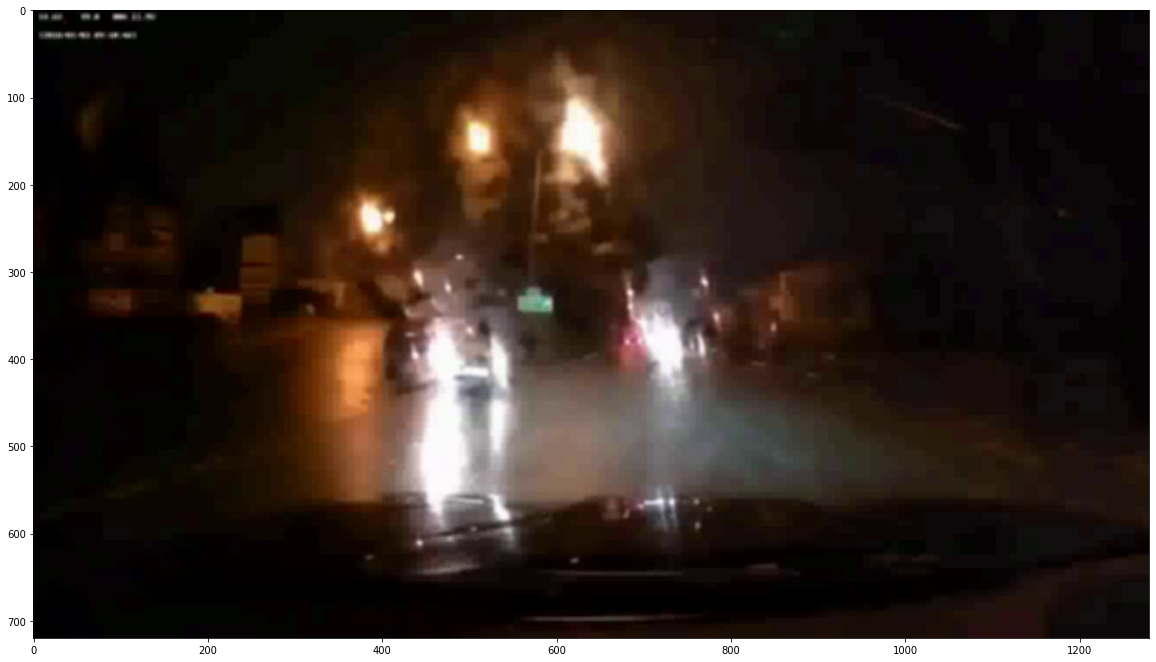

In [19]:
path = './data/50frame_train/TRAIN_0685_024.jpg'
# path = './data/mosaic_test/TEST_0056.jpg'

img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (20,20))

plt.imshow(img)

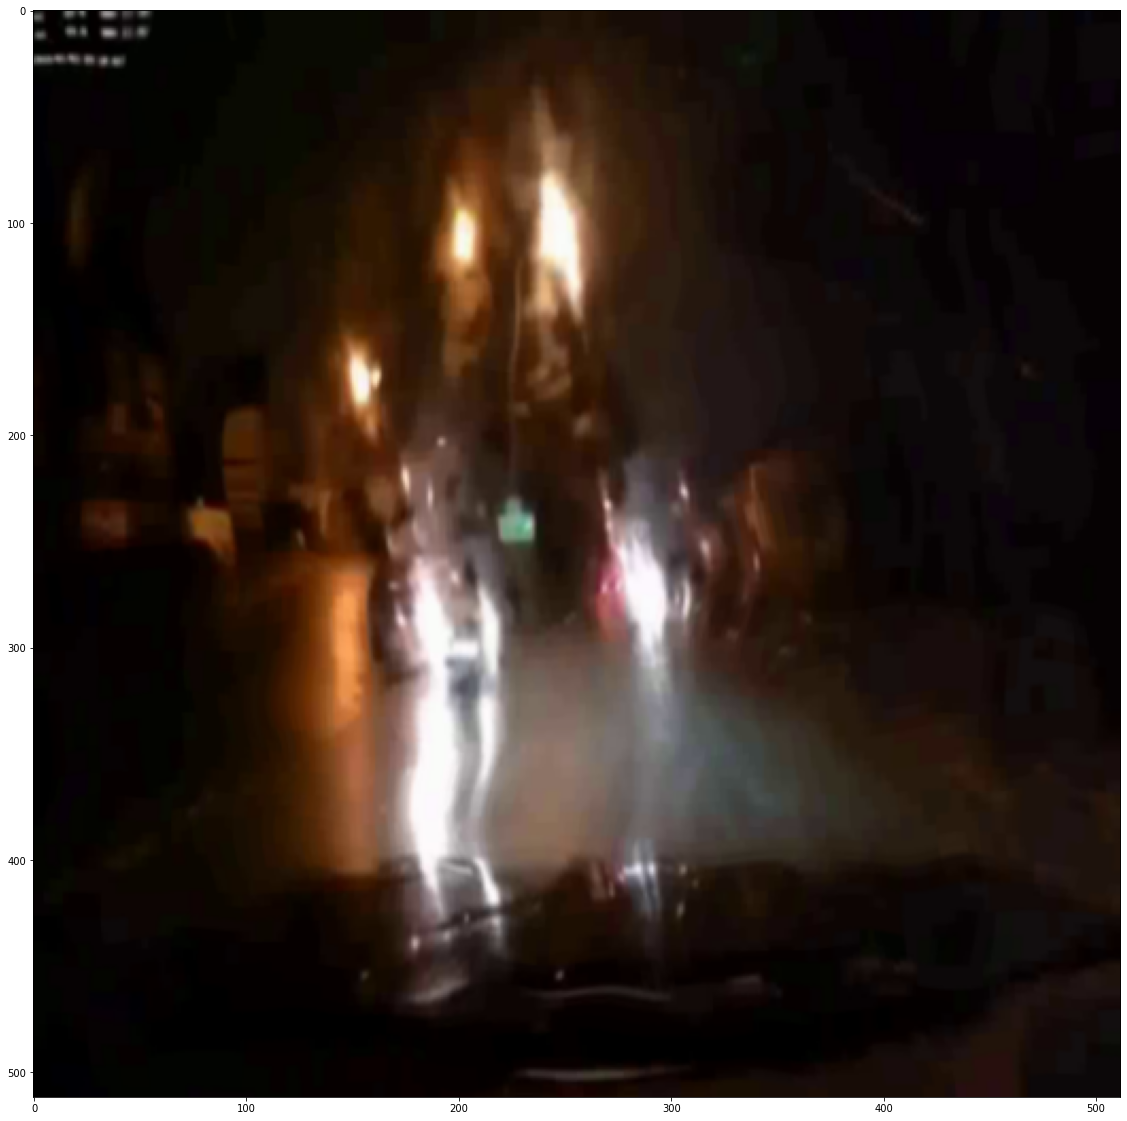

In [24]:
plt.figure(figsize = (20,20))
transform = A.Compose([
    A.Resize(512, 512),
    # A.Rotate(p=1),
    # A.Blur(blur_limit=(1, 1), p=1),
    # A.ElasticTransform(always_apply=False, p=1, 
    #                  alpha=50.6, sigma=113.359999895095825, 
    #                  alpha_affine=40., 
    #                  interpolation=1, border_mode=1, 
    #                  value=(10, 10, 10), 
    #                  ask_value=None, approximate=True)
    
    A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.1, alpha_affine=120 * 0.1),
    # A.GridDistortion(always_apply=False, p=1, 
    #                  num_steps=1, 
    #                  # img 굴곡 조정
    #                  distort_limit=(-0.1, 0.3), 
    #                  interpolation=2, 
    #                  border_mode=2, 
    #                  value=(0, 0, 0), 
    #                  mask_value=None),
    # A.OpticalDistortion(distort_limit=0.4, shift_limit=0.04, p=1),
    # A.GridDistortion(p=1),
    # A.Affine(scale=(1,1.1), # 이미지 크기 조정
    #          translate_percent=(-0.01, 0.01), # 이미지 이동
    #          translate_px=None, # 픽셀단위로 이미지 이동
    #          rotate=(-15, 15), # 회전 각도 조절
    #          shear=None, # 잡아당기는 효과
    #          interpolation=1, 
    #          mask_interpolation=0, 
    #          cval=5, cval_mask=5, 
    #          mode=0, # 회전 할 떄 남은 부분 색으로 채우기
    #          fit_output=False, # 사진에 맞게 그리기
    #          always_apply=False, p=1),
    # A.CLAHE(p=1),
    # A.ImageCompression(p=1),
    # A.RandomBrightnessContrast(brightness_limit=(-0.3, -0.1),p=1),
    # A.Transpose(p=1),
    # A.PadIfNeeded(min_height=720, min_width=720, p=1)
    # A.RandomGridShuffle(p=1, grid=(7, 7))
])

img_t = transform(image=img)['image']
plt.imshow(img_t)

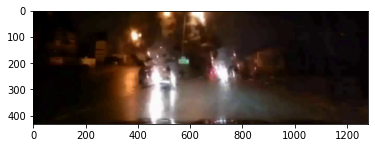

In [6]:
h, w = img.shape[:2]
upper = int(h/2) - int(h * 0.3)
bottom = int(h/2) + int(h * 0.3)

image_2 = img[upper:bottom, :, :]
plt.imshow(image_2)

## stack

In [10]:
import torch
import torch.nn as nn
a = torch.tensor([[1,2,3], [4,5,6], [7,8,9], [10, 11, 12]])
b = torch.tensor([[1,2,3], [4,5,6], [7,8,9], [10, 11, 12]])
c = [a, b]
torch.stack(c).shape

torch.Size([2, 4, 3])

## SlowFast test

In [12]:
import torch
model = torch.hub.load('facebookresearch/pytorchvideo', 'slowfast_r50', pretrained=True)

Using cache found in C:\Users\quhb2/.cache\torch\hub\facebookresearch_pytorchvideo_main
Downloading: "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/kinetics/SLOWFAST_8x8_R50.pyth" to C:\Users\quhb2/.cache\torch\hub\checkpoints\SLOWFAST_8x8_R50.pyth


  0%|          | 0.00/264M [00:00<?, ?B/s]

In [17]:
class SlowFast(nn.Module) :
    def __init__(self) -> None:
        super().__init__()
        self.model = torch.hub.load('facebookresearch/pytorchvideo', 'slowfast_r50', pretrained=True)
        
    def forward(self, x):
        x = self.model(x)
        return x
model = SlowFast()


Using cache found in C:\Users\quhb2/.cache\torch\hub\facebookresearch_pytorchvideo_main


In [21]:
model = torch.hub.load('facebookresearch/pytorchvideo', 'slowfast_r50', pretrained=True)

model.blocks[-1].proj.out_features

Using cache found in C:\Users\quhb2/.cache\torch\hub\facebookresearch_pytorchvideo_main


400

## SlowFast 용 Weather, Ego+crash  csv만들기

In [47]:
### Weather
path = './data/train.csv'
df = pd.read_csv(path)

_df = df[df['label'] != 0]

new_label = []
for label in _df['label'] : 
    
    # normal
    if label in [1,2,7,8] :
        new_label.append(0)
    
    # swnoy
    elif label in [3,4,9,10] :
        new_label.append(1)
    
    # rainy
    elif label in [5,6,11,12] :
        new_label.append(2)

print("normal : ",new_label.count(0))
print("swnoy : ",new_label.count(1))
print("rainy : ",new_label.count(2))

_df['label'] = new_label

path = "./data/Video_weather_train.csv"
_df.to_csv(path, index=False)

normal :  716
swnoy :  129
rainy :  70


C:\Users\quhb2\AppData\Local\Temp\ipykernel_3148\3907291540.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['label'] = new_label


In [48]:
path = "./data/train.csv"
df = pd.read_csv(path)

new_label = []
for label in df['label'] :
    # No ego + No crash
    if label == 0 :
        new_label.append(0)
    
    #No ego + crash = 1
    elif label in [7, 8, 9, 10, 11, 12] : 
        new_label.append(1)
    
    # ego + cash = 2
    elif label in [1, 2, 3, 4, 5, 6] :
        new_label.append(2)
    
print("No ego + No crash : ",new_label.count(0))
print("No ego + crash : ",new_label.count(1))
print("ego + cash : ",new_label.count(2))

df['label'] = new_label

path = "./data/Video_EgoCrash_train.csv"
df.to_csv(path, index=False)

No ego + No crash :  1783
No ego + crash :  424
ego + cash :  491


In [49]:
path = "./data/train.csv"
df = pd.read_csv(path)

_df = df[df['label'] != 0]


new_label = [1 if label % 2 == 1 else 0 for label in _df['label'] ]
print("day : ",new_label.count(1))
print("night : ",new_label.count(0))

_df['label'] = new_label

path = "./data/Video_timing_train.csv"
_df.to_csv(path, index=False)

day :  808
night :  107


C:\Users\quhb2\AppData\Local\Temp\ipykernel_3148\3170221782.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['label'] = new_label


## EVA
- 참고 : https://github.com/siwooyong/4DLand-AI-Challenge-for-block-multi-label-classification/blob/main/model1_training.ipynb

In [44]:
!wget 'https://huggingface.co/timm/eva_large_patch14_336.in22k_ft_in22k_in1k/resolve/main/pytorch_model.bin'


'https://huggingface.co/timm/eva_large_patch14_336.in22k_ft_in22k_in1k/resolve/main/pytorch_model.bin': Scheme missing.


In [27]:
!git clone https://github.com/Alibaba-MIIL/ML_Decoder.git

Cloning into 'ML_Decoder'...


In [ ]:
# !pip install timm==0.8.6.dev0

In [45]:
import torch
from torch import nn
import timm
from timm.models.beit import _create_beit
from timm.models.vision_transformer import _create_vision_transformer, eva_large_patch14_336
from ML_Decoder.src_files.ml_decoder.ml_decoder import MLDecoder

class EVA(nn.Module) :
    def __init__(self, num_classes, enc_dim=1024, pretrained_path="./ckpt/pytorch_model.bin") -> None:
        super(EVA, self).__init__()
        
        self.model = _create_vision_transformer(
            'eva_large_patch14_336', 
            **dict(patch_size=14, embed_dim=enc_dim, depth=24, num_heads=16, global_pool='avg'))
        self.model.load_state_dict(torch.load(pretrained_path))
        self.head = nn.Linear(self.model.head.out_features, num_classes, bias=True)
        # self.head = MLDecoder(num_classes = num_classes, 
        #                         initial_num_features = enc_dim, 
        #                         num_of_groups = -1,
        #                         decoder_embedding = 768, 
        #                         zsl = 0)
        
    def forward(self, x) :
        x = self.model(x)
        x = self.head(x)
        # x = self.model(x)
        return x

In [46]:
test_data = torch.rand(1,3,336, 336)
eva = EVA(
    num_classes=3,
    pretrained_path="./ckpt/eva_large_patch14_336.in22k_ft_in22k_in1k.bin")

In [47]:
test_data = torch.rand(1,3,336, 336)
o = eva(test_data)
print(o.shape)

torch.Size([1, 1000])
torch.Size([1, 3])
torch.Size([1, 3])


In [25]:
model = _create_vision_transformer(
            'eva_large_patch14_336', 
            **dict(patch_size=14,embed_dim=1024, depth=24, num_heads=16, global_pool='avg'))
model.load_state_dict(torch.load("./ckpt/eva_large_patch14_336.in22k_ft_in22k_in1k.bin"))


<All keys matched successfully>

In [29]:
model.blocks[-1].mlp.fc2.out_features

1024

In [37]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
    

In [18]:
test_data = torch.rand(1,3,336, 336)
o = model(test_data)
print(o.shape)

torch.Size([1, 1000])


In [21]:
test_data = torch.rand(1,3,336, 336)
eva = EVA(
    num_classes=3,
    pretrained_path="./ckpt/eva_large_patch14_336.in22k_ft_in22k_in1k.bin")

AttributeError: 'Block' object has no attribute 'proj'

In [14]:
o = eva(test_data)

In [15]:
o.shape

torch.Size([1, 3])

In [66]:
model = _create_beit('eva_giant_patch14_336', pretrained=False)

No pretrained configuration specified for z model. Using a default. Please add a config to the model pretrained_cfg registry or pass explicitly.


In [8]:
import torch
from timm.models.vision_transformer import _create_vision_transformer, eva_large_patch14_336
model_kwargs = dict(patch_size=14, embed_dim=1024, depth=24, num_heads=16, global_pool='avg')
model = _create_vision_transformer('eva_large_patch14_336', **model_kwargs)
# model = eva_large_patch14_336()

In [10]:
model.load_state_dict(torch.load("./ckpt/eva_large_patch14_336.in22k_ft_in22k_in1k.bin"))

<All keys matched successfully>

## Validation의 클래스 비울 확인

In [87]:
from sklearn.model_selection import train_test_split
df = pd.read_csv("./data/Video_timing_train.csv")
train_df, val_df, train_labels, val_labels = train_test_split(
            df.drop(columns=['sample_id']),
            df['label'],
            test_size=0.2,
            random_state=2455
        )

In [88]:
display(train_df['label'].value_counts())
display(val_df['label'].value_counts())

1    649
0     83
Name: label, dtype: int64

1    159
0     24
Name: label, dtype: int64

In [82]:
num_classes=2
num_label = np.array([pd.value_counts(train_df['label'].values)[i] for i in range(num_classes)])
print(torch.tensor(np.max(num_label)/num_label))
print(pd.value_counts(train_df['label'].values))

tensor([7.8193, 1.0000], dtype=torch.float64)
1    649
0     83
dtype: int64


## ETC...

In [3]:
import torch

torch.linspace(0, 49, 49 // 4).shape

torch.Size([12])

In [67]:
import numpy as np

z = np.random.randint(0, 18)
z

11

In [1]:
import timm
model = timm.create_model(
            model_name='gcvit_base', 
            pretrained=True,)

c:\Users\quhb2\Anaconda3\envs\torch-1.11\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights-morevit/gcvit_base_224_nvidia-f009139b.pth" to C:\Users\quhb2/.cache\torch\hub\checkpoints\gcvit_base_224_nvidia-f009139b.pth


In [2]:
model

GlobalContextVit(
  (stem): Stem(
    (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (down): Downsample2d(
      (norm1): LayerNorm2d((128,), eps=1e-05, elementwise_affine=True)
      (conv_block): MbConvBlock(
        (conv_dw): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128, bias=False)
        (act): GELU()
        (se): SEModule(
          (fc1): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): Identity()
          (act): GELU()
          (fc2): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (reduction): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm2): LayerNorm2d((128,), eps=1e-05, elementwise_affine=True)
    )
  )
  (stages): Sequential(
    (0): GlobalContextVitStage(
      (downsample): Iden